In [2]:
from connections.client import BinanceClient
from config.settings import BINANCE_API_KEY, BINANCE_SECRET_KEY, USE_TESTNET
from data.fetch import BinanceDataFetcher,BinanceOptionsFetcher
from datetime import datetime, timedelta
from data.analysis import MarketRegimeAnalyzer
from data.timeseries import (
    hurst,
    permutation_entropy,
    kyles_lambda,
    bekker_parkinson_vol,
    amihuds_lambda,
    hasbroucks_lambda,
    corwin_schultz_hl,
    roll_measure,
)


In [3]:
import importlib
import data.fetch  # Replace 'fetch' with the module name
importlib.reload(data.fetch)
import logging
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Remove all existing logging handlers
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Reconfigure logging
logging.basicConfig(
    level=logging.DEBUG,  # Set to DEBUG to capture all levels
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    stream=sys.stdout  # Direct logs to the console
)

logger = logging.getLogger(__name__)
logger.info("Logging system initialized.")  # Test log


2025-01-14 12:58:47,886 - __main__ - INFO - Logging system initialized.


In [4]:
%load_ext autoreload
%autoreload 2
#!pip install watermark
%load_ext watermark
from os import cpu_count
from pathlib import Path
from typing import Union, List, Dict, Tuple, Iterable, Callable
# import visual tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import numpy as np
import pandas as pd
import hvplot.pandas
import holoviews as hv

hv.renderer("bokeh").theme = "dark_minimal"
from bokeh.models.formatters import NumeralTickFormatter
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef, f1_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)
from statsmodels.tsa.stattools import acf
from joblib import Parallel, delayed
import yfinance as yf
import quantstats_lumi as qs
from ta import add_all_ta_features
from blk_utils import cprint

print()
%watermark -v --iversions

2025-01-14 12:58:52,594 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-01-14 12:58:52,603 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.

Python implementation: CPython
Python version       : 3.9.20
IPython version      : 8.18.1

bokeh          : 3.4.3
sys            : 3.9.20 (main, Dec 11 2024, 00:00:00) 
[GCC 11.4.1 20230605 (Red Hat 11.4.1-2)]
hvplot         : 0.11.2
yfinance       : 0.2.51
statsmodels    : 0.14.4
holoviews      : 1.20.0
logging        : 0.5.1.2
numpy          : 2.0.2
blk_utils      : 0.1.3
matplotlib     : 3.9.4
pandas         : 2.2.3
seaborn        : 0.13.2
quantstats_lumi: 0.1.12
joblib         : 1.4.2
ta             : 0.11.0
sklearn        : 1.6.0
mlxtend        : 0.23.3



In [5]:
SYMBOL = "AAPL"  # SPDR Financial ETF

raw_df = (
    yf.Ticker(SYMBOL)
    .history(period="max")
    .rename(columns=str.lower)
    .loc[:, ["open", "high", "low", "close", "volume"]]
    .ffill()
)


2025-01-14 12:58:52,737 - yfinance - DEBUG - Entering history()
2025-01-14 12:58:52,741 - peewee - DEBUG - ('CREATE TABLE IF NOT EXISTS "_kv" ("key" VARCHAR(255) NOT NULL PRIMARY KEY, "value" VARCHAR(255)) WITHOUT ROWID', [])
2025-01-14 12:58:52,743 - peewee - DEBUG - ('SELECT "t1"."key", "t1"."value" FROM "_kv" AS "t1" WHERE ("t1"."key" = ?) LIMIT ? OFFSET ?', ['AAPL', 1, 0])
2025-01-14 12:58:52,778 - yfinance - DEBUG -  Entering history()
2025-01-14 12:58:52,786 - yfinance - DEBUG - AAPL: Yahoo GET parameters: {'period1': '1926-02-08 07:58:52-05:00', 'period2': '2025-01-14 07:58:52-05:00', 'interval': '1d', 'includePrePost': False, 'events': 'div,splits,capitalGains'}
2025-01-14 12:58:52,789 - yfinance - DEBUG -   Entering get()
2025-01-14 12:58:52,790 - yfinance - DEBUG -    Entering _make_request()
2025-01-14 12:58:52,792 - yfinance - DEBUG - url=https://query2.finance.yahoo.com/v8/finance/chart/AAPL
2025-01-14 12:58:52,795 - yfinance - DEBUG - params={'period1': -1385204468, 'peri

In [6]:
cprint(raw_df)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                               open      high       low     close     volume
Date                                                                        
1980-12-12 00:00:00-05:00  0.098834  0.099264  0.098834  0.098834  469033600
1980-12-15 00:00:00-05:00  0.094108  0.094108  0.093678  0.093678  175884800
1980-12-16 00:00:00-05:00  0.087232  0.087232  0.086802  0.086802  105728000
1980-12-17 00:00:00-05:00  0.088951  0.089381  0.088951  0.088951   86441600
1980-12-18 00:00:00-05:00  0.091530  0.091959  0.091530  0.091530   73449600
-------------------------
TAIL num rows: 5
                                 open        high         low       close  \
Date                                                                        
2025-01-06 00:00:00-05:00  244.309998  247.330002  243.199997  24

In [7]:
train_year_start = 2000
train_year_end = 2012
validation_year_start = 2013
validation_year_end = 2018
test_year_start = 2019
test_year_end = 2023
df = raw_df.copy()
df_train = df.loc[str(train_year_start) : str(train_year_end)]
cprint(df_train, 2)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 2
                               open      high       low     close     volume
Date                                                                        
2000-01-03 00:00:00-05:00  0.789884  0.847313  0.765877  0.843076  535796800
2000-01-04 00:00:00-05:00  0.815303  0.833191  0.762111  0.771997  512377600
-------------------------
TAIL num rows: 2
                                open       high        low      close  \
Date                                                                    
2012-12-28 00:00:00-05:00  15.509879  15.637231  15.443922  15.488602   
2012-12-31 00:00:00-05:00  15.517167  16.273073  15.470664  16.174898   

                              volume  
Date                                  
2012-12-28 00:00:00-05:00  354278400  
2012-12-31 00:00:00-05:00  659492400  
-

In [8]:
df_validation = df.loc[str(validation_year_start) : str(validation_year_end)]
cprint(df_validation, 2)
df_test = df.loc[str(test_year_start) : str(test_year_end)]
cprint(df_test, 2)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 2
                                open       high        low      close  \
Date                                                                    
2013-01-02 00:00:00-05:00  16.832929  16.868794  16.462424  16.687340   
2013-01-03 00:00:00-05:00  16.652386  16.706792  16.443274  16.476707   

                              volume  
Date                                  
2013-01-02 00:00:00-05:00  560518000  
2013-01-03 00:00:00-05:00  352965200  
-------------------------
TAIL num rows: 2
                                open       high        low      close  \
Date                                                                    
2018-12-28 00:00:00-05:00  37.608317  37.851876  36.903908  37.305061   
2018-12-31 00:00:00-05:00  37.854260  38.052450  37.364754  37.665623   

                

In [9]:
def make_forward_returns(
    price_dataframe: pd.DataFrame, horizon: int, column_to_use: str = "close"
) -> pd.DataFrame:
    returns = price_dataframe[column_to_use].pct_change(horizon).shift(-horizon).dropna()
    return returns


def add_target_column_to_df(
    dataframe: pd.DataFrame, forward_returns_series: pd.Series, y_target_col: str
) -> pd.DataFrame:
    out = dataframe.copy()

    out[y_target_col] = forward_returns_series.apply(np.sign)

    print("class value counts before drop zeros:\n", out[y_target_col].value_counts())

    # remove zeros
    out = out[out[y_target_col] != 0.0]
    print("class value counts after drop zeros:\n", out[y_target_col].value_counts())
    return out


def create_Xy(
    indf: pd.DataFrame, feature_cols: List[str], y_target_col: str
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    return indf[feature_cols], indf[y_target_col].to_frame()


def get_feature_columns(feature_dataframe: pd.DataFrame, y_target_col: str) -> List[str]:
    cols = [x for x in feature_dataframe.columns if x != y_target_col]
    return cols

In [10]:
hdf_store_fp = "agg_results.h5"
hdf_store = pd.HDFStore(hdf_store_fp, mode="a", complevel=3, complib="blosc:lz4")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [13]:
#pip install --upgrade numpy
print("Updated NumPy version:", np.__version__)

Updated NumPy version: 2.0.2


In [14]:
# ROLLING WINDOW
WINDOW = 30
# PREDICTION HORIZON
HORIZON = 8
# target
Y_TARGET_COL = f"fwd_{HORIZON}"

# make actual returns
ACTUAL_RETURNS = df["close"].pct_change()

# make forward returns
FORWARD_RETURNS = make_forward_returns(df, HORIZON, "close")
cprint(FORWARD_RETURNS, 2)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 2
                              close
Date                               
1980-12-12 00:00:00-05:00  0.130435
1980-12-15 00:00:00-05:00  0.302748
-------------------------
TAIL num rows: 2
                              close
Date                               
2024-12-27 00:00:00-05:00 -0.073321
2024-12-30 00:00:00-05:00 -0.070579
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11104 entries, 1980-12-12 00:00:00-05:00 to 2024-12-30 00:00:00-05:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   11104 non-null  float64
dtypes: float64(1)
memory usage: 173.5 KB
None
-------------------------------------------------------------------------------



In [15]:
df_train = df_train.pipe(add_target_column_to_df, FORWARD_RETURNS, Y_TARGET_COL)
df_train = add_target_column_to_df(df_train, FORWARD_RETURNS, Y_TARGET_COL)

cprint(df_train)

class value counts before drop zeros:
 fwd_8
 1.0    1877
-1.0    1391
 0.0       1
Name: count, dtype: int64
class value counts after drop zeros:
 fwd_8
 1.0    1877
-1.0    1391
Name: count, dtype: int64
class value counts before drop zeros:
 fwd_8
 1.0    1877
-1.0    1391
Name: count, dtype: int64
class value counts after drop zeros:
 fwd_8
 1.0    1877
-1.0    1391
Name: count, dtype: int64
-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 5
                               open      high       low     close     volume  \
Date                                                                           
2000-01-03 00:00:00-05:00  0.789884  0.847313  0.765877  0.843076  535796800   
2000-01-04 00:00:00-05:00  0.815303  0.833191  0.762111  0.771997  512377600   
2000-01-05 00:00:00-05:00  0.781411  0.832720  0.775762  0.783293  778321600   
20

In [16]:
feature_columns = get_feature_columns(df_train, Y_TARGET_COL)
X, y = create_Xy(df_train, feature_columns, Y_TARGET_COL)
cprint(X, 2)
cprint(y, 2)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
HEAD num rows: 2
                               open      high       low     close     volume
Date                                                                        
2000-01-03 00:00:00-05:00  0.789884  0.847313  0.765877  0.843076  535796800
2000-01-04 00:00:00-05:00  0.815303  0.833191  0.762111  0.771997  512377600
-------------------------
TAIL num rows: 2
                                open       high        low      close  \
Date                                                                    
2012-12-28 00:00:00-05:00  15.509879  15.637231  15.443922  15.488602   
2012-12-31 00:00:00-05:00  15.517167  16.273073  15.470664  16.174898   

                              volume  
Date                                  
2012-12-28 00:00:00-05:00  354278400  
2012-12-31 00:00:00-05:00  659492400  
-

In [3]:
# Test settings
print("API Key:", BINANCE_API_KEY)
print("Testnet Mode:", USE_TESTNET)

# Test the BinanceClient
client = BinanceClient()
print(client.test_connection())

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


API Key: FdEFwUP7BbC4y4GshdHi3SuGaWUTmqABFUSD1J3tySAGxsxGAumA9zaeR5wYI9RVFdEFwUP7BbC4y4GshdHi3SuGaWUTmqABFUSD1J3tySAGxsxGAumA9zaeR5wYI9RV
Testnet Mode: False
2025-01-14 05:51:26,373 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): api.binance.com:443
2025-01-14 05:51:26,634 - urllib3.connectionpool - DEBUG - https://api.binance.com:443 "GET /api/v3/ping HTTP/1.1" 200 2
Initialized Binance Client (Testnet: False)
2025-01-14 05:51:26,887 - urllib3.connectionpool - DEBUG - https://api.binance.com:443 "GET /api/v3/ping HTTP/1.1" 200 2
Connection successful: {}
{}


In [4]:
import os
print(os.getcwd())
import sys
print(sys.path)


/home/ec2-user/BinanceEDA
['/usr/lib64/python39.zip', '/usr/lib64/python3.9', '/usr/lib64/python3.9/lib-dynload', '', '/home/ec2-user/.local/lib/python3.9/site-packages', '/home/ec2-user/BinanceEDA', '/usr/lib64/python3.9/site-packages', '/usr/lib/python3.9/site-packages']


In [7]:
# Initialize the data fetcher
fetcher = BinanceDataFetcher()

# Define parameters
symbol = "XRPUSDT"  # Trading pair
interval = "15m"  # intervals here
start_days_ago = 2000  # Start time: 1 day ago
end_days_ago = 0  # End time: now

# Create a dynamic output file name
output_file = f"{symbol}_{interval}_day{start_days_ago}_day{end_days_ago}.csv"

# Print the dynamic file name to verify
print(f"Output file name: {output_file}")


try:
    # Calculate start and end timestamps
    start_time = datetime.now() - timedelta(days=start_days_ago)
    end_time = datetime.now() - timedelta(days=end_days_ago)

    # Log the calculated timestamps
    print(f"Start Time: {start_time} ({int(start_time.timestamp() * 1000)} ms)")
    print(f"End Time: {end_time} ({int(end_time.timestamp() * 1000)} ms)")

    # Fetch and save data
    fetcher.fetch_and_save_historical_data(
        symbol=symbol,
        interval=interval,
        start_days_ago=start_days_ago,
        end_days_ago=end_days_ago,
        output_file=output_file
    )

    print(f"Data successfully saved to {output_file}")

except OverflowError as oe:
    print(f"OverflowError occurred: {oe}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

2025-01-14 05:52:35,007 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): api.binance.com:443
2025-01-14 05:52:35,272 - urllib3.connectionpool - DEBUG - https://api.binance.com:443 "GET /api/v3/ping HTTP/1.1" 200 2
Initialized Binance Client (Testnet: False)
Output file name: XRPUSDT_15m_day2000_day0.csv
Start Time: 2019-07-25 05:52:35.274752 (1564033955274 ms)
End Time: 2025-01-14 05:52:35.274761 (1736833955274 ms)
2025-01-14 05:52:35,274 - data.fetch - INFO - Fetching historical data for XRPUSDT from 2019-07-25 05:52:35.274000 to 2025-01-14 05:52:35.274000 with 15m interval.
2025-01-14 05:52:35,277 - data.fetch - INFO - Fetching data from 2019-07-25 05:52:35.274000 to 2019-08-04 15:52:35.274000.
2025-01-14 05:52:35,278 - data.fetch - INFO - Fetching candlestick data for XRPUSDT with interval 15m, startTime 1564033955274, endTime 1564933955274, limit 1000.
2025-01-14 05:52:35,547 - urllib3.connectionpool - DEBUG - https://api.binance.com:443 "GET /api/v3/klines?end

In [7]:
print(f"Start Time (ms): {start_days_ago}, {datetime.fromtimestamp(start_days_ago / 1000)}")
print(f"End Time (ms): {end_days_ago}, {datetime.fromtimestamp(end_days_ago / 1000)}")


Start Time (ms): 1800, 1970-01-01 00:00:01.800000
End Time (ms): 0, 1970-01-01 00:00:00


In [ ]:
import importlib
import data.fetch  # Replace 'fetch' with the module name
importlib.reload(data.fetch)


In [ ]:
# Initialize the options fetcher
options_fetcher = BinanceOptionsFetcher(api_key=BINANCE_API_KEY, api_secret=BINANCE_SECRET_KEY)

# Define the option symbol
option_symbol = "BTC-250328-90000-P"  # Replace with a valid symbol if necessary

# Fetch and print option info
print(f"Fetching option info for {option_symbol}...")

try:
    option_info = options_fetcher.get_option_info(option_symbol)
    print("Option Info Retrieved Successfully:")
    print(option_info)
except Exception as e:
    print(f"Error fetching option info: {e}")

# Get current price
current_price = options_fetcher.get_current_option_price(option_symbol)
print(f"Current Price: {current_price}")

# Get historical klines
klines = options_fetcher.get_historical_option_klines(option_symbol, interval="1h", limit=50)
print(f"Historical Klines: {klines}")

# Get recent trades
recent_trades = options_fetcher.get_recent_option_trades(option_symbol, limit=5)
print(f"Recent Trades: {recent_trades}")

In [ ]:
# Initialize the HMM Analyzer
hmm_analyzer = HMMAnalyzer(n_components=3, covariance_type='diag', n_iter=1000, random_state=42)
# File and columns to analyze
file_path = "BTCUSDT_15m_day1800_day0.csv"

# Load the dataset
data = pd.read_csv(file_path, parse_dates=["timestamp"])

# Display the first few rows
print(data.head())

# Ensure selected columns are present
columns_to_analyze = ["timestamp", "open", "high", "low", "close", "volume"]
for col in columns_to_analyze:
    if col not in data.columns:
        raise ValueError(f"Column {col} not found in the dataset.")

In [ ]:
# Calculate log-returns
data['log_return'] = np.log(data['close'] / data['close'].shift(1))

# Calculate volatility as the rolling standard deviation of log-returns
data['volatility'] = data['log_return'].rolling(window=20).std()

# Normalize volume
data['normalized_volume'] = data['volume'] / data['volume'].rolling(window=20).mean()

# Drop NaN values introduced by rolling calculations
data = data.dropna()

# Features for HMM
features = data[['log_return', 'volatility', 'normalized_volume']].values

2024-12-31 05:11:18,034 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-31 05:11:18,040 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-31 05:11:18,079 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-31 05:11:18,082 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/ec2-user/.local/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-31 05:11:18,084 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/home/ec2-user/.local/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stret

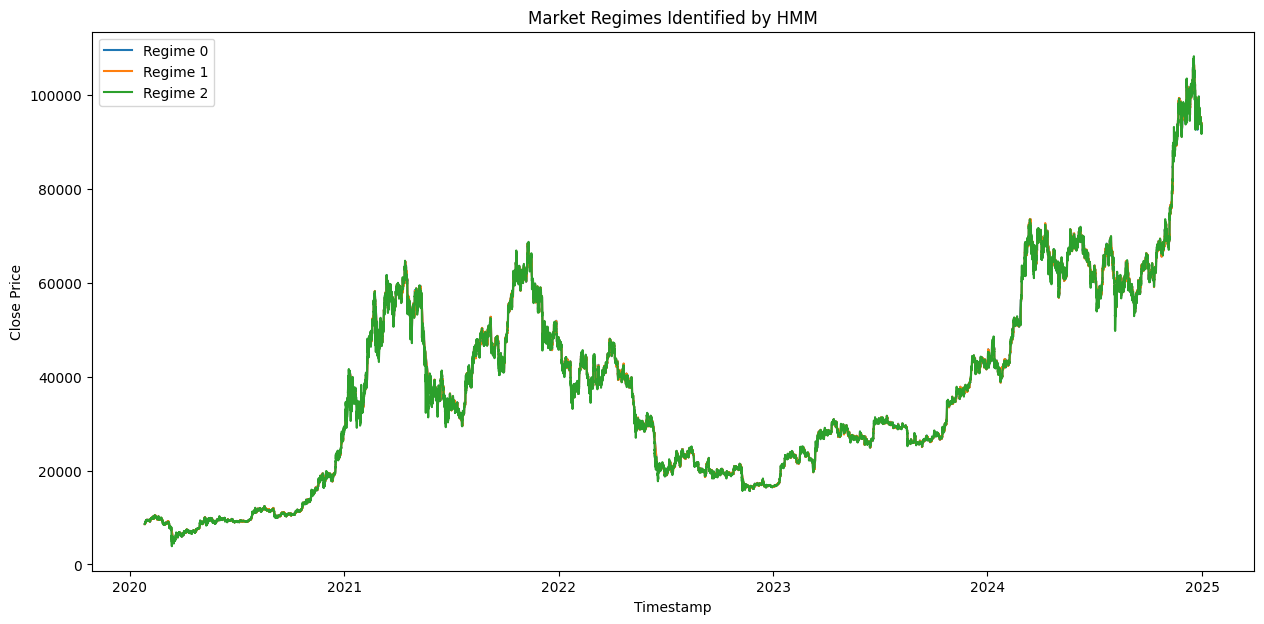

Data with regimes saved to BTCUSDT_15m_day1800_day0_with_regimes.csv


In [5]:
# Define file path and columns
file_path = "BTCUSDT_15m_day1800_day0.csv"
columns = ["timestamp", "open", "high", "low", "close", "volume"]

# Initialize the analyzer
analyzer = MarketRegimeAnalyzer(file_path=file_path, columns=columns)

try:
    # Load data and preprocess
    analyzer.load_data()

    # Train the HMM model
    analyzer.train_hmm()

    # Predict regimes
    analyzer.predict_regimes()

    # Visualize the regimes
    analyzer.visualize_regimes()

    # Save the results
    output_file = file_path.replace(".csv", "_with_regimes.csv")
    analyzer.save_results(output_file)

except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# Load the data
file_path = "BTCUSDT_15m_day1800_day0_with_regimes.csv"  # Update to your file path
data = pd.read_csv(file_path, parse_dates=["timestamp"])

# Define colors for each regime
color_map = {
    0: 'lightcoral',  # Regime 0
    1: 'lightblue',   # Regime 1
    2: 'lightgreen'   # Regime 2
}

# Set up the plot
plt.figure(figsize=(15, 7))
ax = plt.gca()

# Iterate over the data and plot regime-based background
for i in range(len(data) - 1):
    start_time = data['timestamp'].iloc[i]
    end_time = data['timestamp'].iloc[i + 1]
    regime = data['regime'].iloc[i]
    ax.axvspan(
        start_time,
        end_time,
        facecolor=color_map[regime],
        alpha=0.2  # Transparency for background shading
    )

# Plot the price line
plt.plot(data['timestamp'], data['close'], color="black", linewidth=1.5, label="Close Price")

# Format the x-axis for better readability
date_formatter = DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_formatter)
plt.xticks(rotation=45)

# Add labels and legend
plt.title("Market Regimes with Dynamic Background Colors")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


KeyboardInterrupt: 